In [1]:
from pathlib import Path
from tqdm import tqdm
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

import rebound as rb
import sys
sys.path.append('../')
from linear_theory import linear_theory_prediction, make_simpler_secular_theory

plt.style.use('../paper.mplstyle')

base_path = Path("../data")

In [2]:
uncertainty_asteroids_sampled = pd.read_csv(base_path/"uncertainty_asteroids_sampled.csv")
# merge asteroid index and designator into one column
uncertainty_asteroids_sampled["Des'n"] = uncertainty_asteroids_sampled["Des'n"] + "-" + uncertainty_asteroids_sampled[uncertainty_asteroids_sampled.columns[0]].astype(str)
uncertainty_asteroids_sampled = uncertainty_asteroids_sampled.drop(columns=[uncertainty_asteroids_sampled.columns[0]])

uncertainty_asteroids_proper_elements = pd.read_csv(base_path/"uncertainty_asteroid_elements_proper.csv", index_col=0)

uncertainty_asteroids = pd.merge(uncertainty_asteroids_sampled, uncertainty_asteroids_proper_elements, on="Des'n", how="inner")
uncertainty_asteroids.head()

,Des'n,epoch,x,y,z,vx,vy,vz,g,s,propa,prope,propsini
0,K23Q65H-0,2460193.5,2.089677,-0.471412,-0.050662,1.119444,4.371910,-0.160598,39.448867,-40.817830,2.399421,0.076069,0.033174
1,K23Q65H-1,2460193.5,2.083370,-0.470422,-0.050383,1.126286,4.379951,-0.159831,39.281278,-40.698449,2.395599,0.077768,0.032973
2,K23Q65H-2,2460193.5,2.104747,-0.474021,-0.051316,1.113403,4.351187,-0.162884,39.664863,-41.193396,2.409175,0.074555,0.033692
3,K23Q65H-3,2460193.5,2.103007,-0.473237,-0.051251,1.105546,4.355013,-0.162204,39.584892,-41.067235,2.406828,0.073510,0.033651
4,K23Q65H-4,2460193.5,2.084378,-0.470628,-0.050423,1.114949,4.380133,-0.159520,39.215266,-40.612570,2.394750,0.075792,0.033164


In [3]:
from multiprocessing import Pool

simpler_secular_theory = make_simpler_secular_theory()

def ecc_inc_prediction(r):
    idx, row = r
    sim = rb.Simulationarchive(str(base_path/"uncertainty_integrations"/f"asteroid_integration_{row["Des'n"]}.sa"))[0]

    u, v, g, s = linear_theory_prediction(sim.particles[-1].e, sim.particles[-1].inc, sim.particles[-1].omega, sim.particles[-1].Omega, sim.particles[-1].a,
                             row['propa'], simpler_secular_theory)
    
    return (row["Des'n"], 
            sim.particles[-1].e, sim.particles[-1].inc, sim.particles[-1].omega, sim.particles[-1].Omega, sim.particles[-1].a,
            np.abs(u.item()), np.abs(v.item()), g.item(), s.item()
            )

with Pool(40) as p:
    table = list(tqdm(p.imap(ecc_inc_prediction, uncertainty_asteroids.iterrows()), total=len(uncertainty_asteroids)))

100%|██████████| 2732/2732 [00:08<00:00, 336.27it/s]


In [4]:
df_linear = pd.DataFrame(table, columns=["Des'n", "e", "Incl.", "Node", "Peri.", "a", "prope_h", "propsini_h", "g0", "s0"])
uncertainty_asteroids = pd.merge(uncertainty_asteroids, df_linear, on="Des'n", how="inner")
uncertainty_asteroids.head()

,Des'n,epoch,x,y,z,vx,vy,vz,g,s,...,propsini,e,Incl.,Node,Peri.,a,prope_h,propsini_h,g0,s0
0,K23Q65H-0,2460193.5,2.089677,-0.471412,-0.050662,1.119444,4.371910,-0.160598,39.448867,-40.817830,...,0.033174,0.104013,0.042185,3.432956,2.323581,2.372563,0.134288,0.054369,0.00003,-0.00003
1,K23Q65H-1,2460193.5,2.083370,-0.470422,-0.050383,1.126286,4.379951,-0.159831,39.281278,-40.698449,...,0.032973,0.105500,0.041935,3.430417,2.321079,2.368948,0.135864,0.054202,0.00003,-0.00003
2,K23Q65H-2,2460193.5,2.104747,-0.474021,-0.051316,1.113403,4.351187,-0.162884,39.664863,-41.193396,...,0.033692,0.101537,0.042817,3.417279,2.330099,2.382548,0.130909,0.054797,0.00003,-0.00003
3,K23Q65H-3,2460193.5,2.103007,-0.473237,-0.051251,1.105546,4.355013,-0.162204,39.584892,-41.067235,...,0.033651,0.100966,0.042708,3.436645,2.328824,2.380193,0.131055,0.054739,0.00003,-0.00003
4,K23Q65H-4,2460193.5,2.084378,-0.470628,-0.050423,1.114949,4.380133,-0.159520,39.215266,-40.612570,...,0.033164,0.104131,0.041944,3.453328,2.321032,2.368097,0.135264,0.054237,0.00003,-0.00003


In [5]:
final_model_e = xgb.XGBRegressor()
final_model_e.load_model(base_path/"models/best_model_e_final.xgb")
final_model_inc = xgb.XGBRegressor()
final_model_inc.load_model(base_path/"models/best_model_inc_final.xgb")

In [ ]:
uncertainty_asteroids['ecospo'] = uncertainty_asteroids['prope_h']*np.cos((uncertainty_asteroids['Node']+uncertainty_asteroids['Peri.'])*np.pi/180)
uncertainty_asteroids['esinpo'] = uncertainty_asteroids['prope_h']*np.sin((uncertainty_asteroids['Node']+uncertainty_asteroids['Peri.'])*np.pi/180)
uncertainty_asteroids['sinicosO'] = np.sin(uncertainty_asteroids['propsini_h']*np.pi/180)*np.cos(uncertainty_asteroids['Node']*np.pi/180)
uncertainty_asteroids['sinisinO'] = np.sin(uncertainty_asteroids['propsini_h']*np.pi/180)*np.sin(uncertainty_asteroids['Node']*np.pi/180)

features_e = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'a', 'g0', 'prope_h']
features_inc = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'a', 's0', 'propsini_h']
data_e = uncertainty_asteroids[features_e]
data_inc = uncertainty_asteroids[features_inc]

pred_dele = final_model_e.predict(data_e)
pred_delsini = final_model_inc.predict(data_inc)

pred_e = pred_dele + uncertainty_asteroids["e"]
pred_e[pred_e < 0] = 0 # clamp values less than 0
uncertainty_asteroids["pred_e"] = pred_e

pred_sini = pred_delsini + np.sin(uncertainty_asteroids["Incl."])
uncertainty_asteroids["pred_sini"] = pred_sini

# Plotting

In [7]:
merged_df = pd.read_csv("../data/merged_elements.csv", index_col=0)

/tmp/ipykernel_111174/3322480553.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("../data/merged_elements.csv", index_col=0)


In [8]:
def mad_std(data):
    mad = np.median(np.abs(data - np.median(data)))
    return 1.4826 * mad

K23Q65H
prope vs pred_e 0.00303 0.00195
propsini vs pred_sini 0.000564 0.000374
K23Q67X
prope vs pred_e 0.00293 0.00232
propsini vs pred_sini 0.00123 0.000278


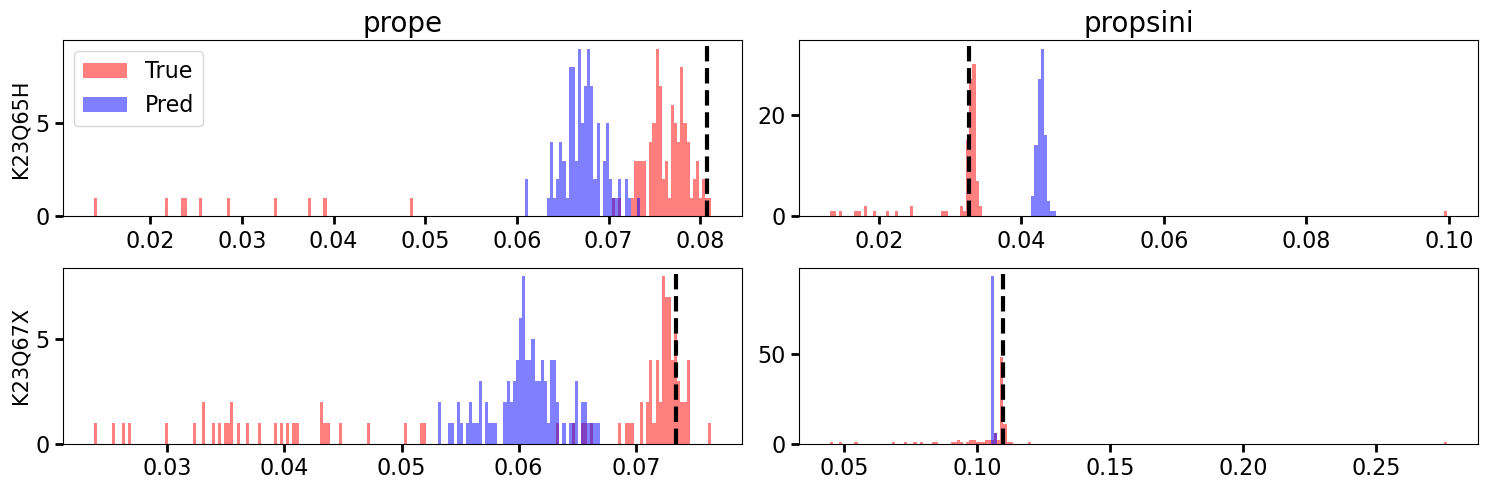

In [9]:

target_asteroids = ["K23Q65H", "K23Q67X"]
qtys_true = ["prope", "propsini"]
qtys_pred = ["pred_e", "pred_sini"]

fig, axs = plt.subplots(len(target_asteroids), len(qtys_true), figsize=(15, 5))

for i, asteroid in enumerate(target_asteroids):
    print(asteroid)
    row = merged_df[merged_df["Des'n"] == asteroid]
    axs[i, 0].set_ylabel(asteroid, size=15)

    for j, (true_col, pred_col) in enumerate(zip(qtys_true, qtys_pred)):
        if i == 0:
            axs[i, j].set_title(true_col, size=20)
        clones_df = uncertainty_asteroids[uncertainty_asteroids["Des'n"].str.contains(asteroid)]
        combined_data = np.concatenate([clones_df[true_col], clones_df[pred_col]])

        bins = np.linspace(combined_data.min(), combined_data.max(), 200)
        # bins = 30
        axs[i, j].hist(clones_df[true_col], bins=bins, color="red", alpha=0.5, label="True")
        axs[i, j].hist(clones_df[pred_col], bins=bins, color="blue", alpha=0.5, label="Pred")
        # print(true_col, "vs", pred_col, f"{mad_std(clones_df[true_col]):.3} {mad_std(clones_df[pred_col]):.3}")
        
        axs[i, j].axvline(row[true_col].item(), linestyle="--", color="black")
        axs[i, j].tick_params(axis='both', labelsize=16)
        
        if i == 0 and j == 0:
            axs[i, j].legend()

plt.tight_layout()
plt.show()

In [10]:
base_asteroids = uncertainty_asteroids["Des'n"].apply(lambda d: d.split("-")[0])

rows = []
for asteroid in base_asteroids:
    clones_df = uncertainty_asteroids[uncertainty_asteroids["Des'n"].str.contains(asteroid)]
    rows.append([asteroid, mad_std(clones_df['prope']), mad_std(clones_df['propsini']), mad_std(clones_df['pred_e']), mad_std(clones_df['pred_sini'])])

stats_df = pd.DataFrame(rows, columns=["Des'n", "prope_std", "propsini_std", "prede_std", "predsini_std"])

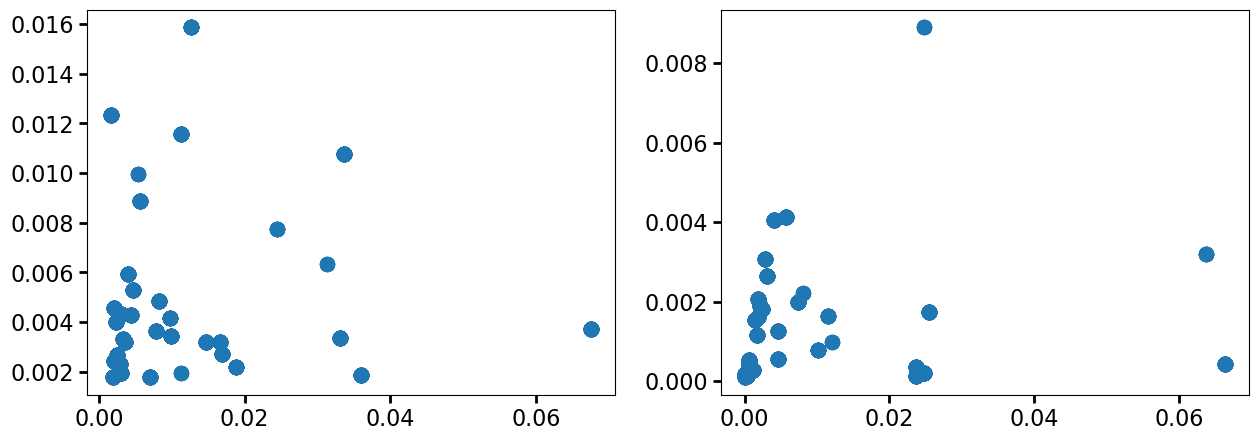

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(stats_df['prope_std'], stats_df['prede_std'])
axs[1].scatter(stats_df['propsini_std'], stats_df['predsini_std'])